In [249]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from kaggle.api.kaggle_api_extended import KaggleApi
import os
from thefuzz import process
import pprint
from IPython.display import display, HTML
import base64
import random
import seaborn as sns


### Анализ и обработка мультимодального датасета

В данном документе представлено решение по практическому заданию #3 курса DC-AI. 

Рассматриваются следующие датасеты с мультимодальными данными:
- датасет с huggingface [huggan/wikiart](https://huggingface.co/datasets/huggan/wikiart), содержащий более 80 тысяч аннотированных фотографий произведений изобразительного искусства с сайта `wikiart.org`;
- датасет с kaggle [ikarus777/best-artworks-of-all-time](https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time/data), содержащий информацию о 50 самых влиятельных художниках и набор их картин, данные взяты с сайта `artchallenge.ru`.

Оба датасета можно охарактеризовать как мультимодальные в связи с наличием текстовых данных и связанных с ними исходных изображений.

За основу взят датасет `best-artworks-of-all-time`. В этом датасете нет разметки изображений, кроме связи с автором. Он будет дополнен датасетом `wikiart`, в котором каждому изображению присвоены лейблы `style`,  `genre`. 

Список работ для нормализации и анализа данных:
1. охарактеризовать датасеты, описать принцип связки мультимодельных данных;
2. обработать данные, объединить датасеты;
3. провести EDA;
4. составить возможные кейсы использования полученных мультимодальных данных.


---

**Загрузка датасетов**

In [250]:
dataset_best_artworks_folder = 'data/best-artworks-of-all-time/'
if not os.path.exists(os.path.join(dataset_best_artworks_folder, 'artists.csv')):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files('ikarus777/best-artworks-of-all-time',
                               path=dataset_best_artworks_folder, unzip=True)

dataset_art: Dataset = load_dataset("huggan/wikiart", cache_dir="./data/wikiart", split="train")

Resolving data files: 100%|██████████| 72/72 [00:10<00:00,  7.07it/s]


**Характеристика датасета `best-artworks-of-all-time`**

In [251]:
%%bash
# проверим структуру папки, содержащей датасет
tree -L 2 ./data/best-artworks-of-all-time

./data/best-artworks-of-all-time
├── artists.csv
├── images
│   └── images
└── resized
    └── resized

5 directories, 1 file


In [252]:
%%bash
# проверим структуру папки изображений
tree -L 2 ./data/best-artworks-of-all-time/images

./data/best-artworks-of-all-time/images
└── images
    ├── Albrecht_DuΓòá├¬rer
    ├── Albrecht_Du╠êrer
    ├── Alfred_Sisley
    ├── Amedeo_Modigliani
    ├── Andrei_Rublev
    ├── Andy_Warhol
    ├── Camille_Pissarro
    ├── Caravaggio
    ├── Claude_Monet
    ├── Diego_Rivera
    ├── Diego_Velazquez
    ├── Edgar_Degas
    ├── Edouard_Manet
    ├── Edvard_Munch
    ├── El_Greco
    ├── Eugene_Delacroix
    ├── Francisco_Goya
    ├── Frida_Kahlo
    ├── Georges_Seurat
    ├── Giotto_di_Bondone
    ├── Gustav_Klimt
    ├── Gustave_Courbet
    ├── Henri_Matisse
    ├── Henri_Rousseau
    ├── Henri_de_Toulouse-Lautrec
    ├── Hieronymus_Bosch
    ├── Jackson_Pollock
    ├── Jan_van_Eyck
    ├── Joan_Miro
    ├── Kazimir_Malevich
    ├── Leonardo_da_Vinci
    ├── Marc_Chagall
    ├── Michelangelo
    ├── Mikhail_Vrubel
    ├── Pablo_Picasso
    ├── Paul_Cezanne
    ├── Paul_Gauguin
    ├── Paul_Klee
    ├── Peter_Paul_Rubens
    ├── Pierre-Auguste_Renoir
    ├── Piet_Mondrian
    ├── Pie

In [253]:
%%bash
# проверим структуру файлов в первой папке с изображениями
find ./data/best-artworks-of-all-time/images/images/* -maxdepth 1 | head -n 1 | xargs -r ls

Albrecht_DuΓòá├¬rer_1.jpg
Albrecht_DuΓòá├¬rer_10.jpg
Albrecht_DuΓòá├¬rer_100.jpg
Albrecht_DuΓòá├¬rer_101.jpg
Albrecht_DuΓòá├¬rer_102.jpg
Albrecht_DuΓòá├¬rer_103.jpg
Albrecht_DuΓòá├¬rer_104.jpg
Albrecht_DuΓòá├¬rer_105.jpg
Albrecht_DuΓòá├¬rer_106.jpg
Albrecht_DuΓòá├¬rer_107.jpg
Albrecht_DuΓòá├¬rer_108.jpg
Albrecht_DuΓòá├¬rer_109.jpg
Albrecht_DuΓòá├¬rer_11.jpg
Albrecht_DuΓòá├¬rer_110.jpg
Albrecht_DuΓòá├¬rer_111.jpg
Albrecht_DuΓòá├¬rer_112.jpg
Albrecht_DuΓòá├¬rer_113.jpg
Albrecht_DuΓòá├¬rer_114.jpg
Albrecht_DuΓòá├¬rer_115.jpg
Albrecht_DuΓòá├¬rer_116.jpg
Albrecht_DuΓòá├¬rer_117.jpg
Albrecht_DuΓòá├¬rer_118.jpg
Albrecht_DuΓòá├¬rer_119.jpg
Albrecht_DuΓòá├¬rer_12.jpg
Albrecht_DuΓòá├¬rer_120.jpg
Albrecht_DuΓòá├¬rer_121.jpg
Albrecht_DuΓòá├¬rer_122.jpg
Albrecht_DuΓòá├¬rer_123.jpg
Albrecht_DuΓòá├¬rer_124.jpg
Albrecht_DuΓòá├¬rer_125.jpg
Albrecht_DuΓòá├¬rer_126.jpg
Albrecht_DuΓòá├¬rer_127.jpg
Albrecht_DuΓòá├¬rer_128.jpg
Albrecht_DuΓòá├¬rer_129.jpg
Albrecht_DuΓòá├¬rer_13.jpg
Albrecht_DuΓòá├¬rer_130.jp

In [254]:
%%bash
# проверим структуру файлов в папке с ресайзнутыми изображениями
ls ./data/best-artworks-of-all-time/resized/resized | head -n 5

Albrecht_DuΓòá├¬rer_1.jpg
Albrecht_DuΓòá├¬rer_10.jpg
Albrecht_DuΓòá├¬rer_100.jpg
Albrecht_DuΓòá├¬rer_101.jpg
Albrecht_DuΓòá├¬rer_102.jpg


Датасет `best-artworks-of-all-time` содержит следующую файловую структуру:

- `./artists.csv` - файл, содержащий данные о художниках;
- `./images/images/<author_name>/<art_identification>` - папка `images/images` подразделяется на директории, содержащие фотографии картин, сгруппированных по имени автора произведения, идентификатор картины состоит из имени автор и индекса картины, например `Albrecht_Durer_1`;
- `./resized/resized/<author_name>` - директория `resized/resized` содержит фотографии картин с измененным разрешением.

Датасет является мультимодальным. Принцип связки следующий: декларация списка художников в `artists.csv`, для каждого художника с идентификацией по его имени существует соответствующая директория в `images/images/*`, внутри директории содержатся все картины художника.

In [255]:
dataset_artists = pd.read_csv(
    'data/best-artworks-of-all-time/artists.csv', index_col='id')

print(dataset_artists.info())
dataset_artists.head()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         50 non-null     object
 1   years        50 non-null     object
 2   genre        50 non-null     object
 3   nationality  50 non-null     object
 4   bio          50 non-null     object
 5   wikipedia    50 non-null     object
 6   paintings    50 non-null     int64 
dtypes: int64(1), object(6)
memory usage: 3.1+ KB
None


name        years                         genre nationality  \
id                                                                              
0    Amedeo Modigliani  1884 - 1920                 Expressionism     Italian   
1   Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism     Russian   
2         Diego Rivera  1886 - 1957       Social Realism,Muralism     Mexican   
3         Claude Monet  1840 - 1926                 Impressionism      French   
4        Rene Magritte  1898 - 1967      Surrealism,Impressionism     Belgian   

                                                  bio  \
id                                                      
0   Amedeo Clemente Modigliani (Italian pronunciat...   
1   Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2   Diego María de la Concepción Juan Nepomuceno E...   
3   Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4   René François Ghislain Magritte (French: [ʁəne...   

                                         wikipedia  paintings  
id                                                             
0   http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1   http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2        http://en.wikipedia.org/wiki/Diego_Rivera         70  
3        http://en.wikipedia.org/wiki/Claude_Monet         73  
4       http://en.wikipedia.org/wiki/René_Magritte        194

---
**Подготовка к проверки целосности данных**

In [256]:
def count_files_in_folder(folder_path):
    if (not isinstance(folder_path, str)):
        return 0
    file_list = os.listdir(folder_path)
    return len(file_list)


ARTIST_NAME_EXPECTED = 'name_expected'
ARTIST_DIR = 'artist_dir'
ARTIST_DIR_PATH = "data/best-artworks-of-all-time/images/images/"


# Копируем, чтобы не мутировать глобальную переменную
dataset_artists_prepared = dataset_artists.copy()

# Копируем, преобразуем имя к виду Diego_Rivera
dataset_artists_prepared[ARTIST_NAME_EXPECTED] = dataset_artists_prepared['name'].apply(
    lambda x: x.replace(' ', '_'))

# создаем датасет всех художников, по которым созданы папки в `ARTIST_DIR_PATH`
dataset_artists_folder_names = [[folder_name, os.path.join(ARTIST_DIR_PATH, folder_name)] for folder_name in os.listdir(
    ARTIST_DIR_PATH) if os.path.isdir(os.path.join(ARTIST_DIR_PATH, folder_name))]
dataset_artists_folder_names = pd.DataFrame(
    dataset_artists_folder_names, columns=[ARTIST_DIR, "artist_dir_path"])

# Объединяем датасеты dataset_artists и датасет с папками
dataset_artists_prepared = pd.merge(dataset_artists_prepared, dataset_artists_folder_names,
                           how="outer", left_on=ARTIST_NAME_EXPECTED, right_on=ARTIST_DIR, indicator=True)

# Проверяем количество файлов в папке, оно должно будет соотв количеству всех картин художника
dataset_artists_prepared['artist_files_in_dir'] = dataset_artists_prepared['artist_dir_path'].apply(
    count_files_in_folder)

# После джоина образовались не найденные значения, выставляем везде paintings = 0
dataset_artists_prepared['paintings'] = dataset_artists_prepared['paintings'].fillna(0)
dataset_artists_prepared['paintings'] = dataset_artists_prepared['paintings'].round().astype(int)

dataset_artists_prepared.info()
dataset_artists_prepared.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   name                 50 non-null     object  
 1   years                50 non-null     object  
 2   genre                50 non-null     object  
 3   nationality          50 non-null     object  
 4   bio                  50 non-null     object  
 5   wikipedia            50 non-null     object  
 6   paintings            52 non-null     int64   
 7   name_expected        50 non-null     object  
 8   artist_dir           51 non-null     object  
 9   artist_dir_path      51 non-null     object  
 10  _merge               52 non-null     category
 11  artist_files_in_dir  52 non-null     int64   
dtypes: category(1), int64(2), object(9)
memory usage: 4.8+ KB


name        years                         genre nationality  \
0   Amedeo Modigliani  1884 - 1920                 Expressionism     Italian   
1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism     Russian   
2        Diego Rivera  1886 - 1957       Social Realism,Muralism     Mexican   
3        Claude Monet  1840 - 1926                 Impressionism      French   
4       Rene Magritte  1898 - 1967      Surrealism,Impressionism     Belgian   

                                                 bio  \
0  Amedeo Clemente Modigliani (Italian pronunciat...   
1  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2  Diego María de la Concepción Juan Nepomuceno E...   
3  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  \
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193   
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88   
2       http://en.wikipedia.org/wiki/Diego_Rivera         70   
3       http://en.wikipedia.org/wiki/Claude_Monet         73   
4      http://en.wikipedia.org/wiki/René_Magritte        194   

        name_expected          artist_dir  \
0   Amedeo_Modigliani   Amedeo_Modigliani   
1  Vasiliy_Kandinskiy  Vasiliy_Kandinskiy   
2        Diego_Rivera        Diego_Rivera   
3        Claude_Monet        Claude_Monet   
4       Rene_Magritte       Rene_Magritte   

                                     artist_dir_path _merge  \
0  data/best-artworks-of-all-time/images/images/A...   both   
1  data/best-artworks-of-all-time/images/images/V...   both   
2  data/best-artworks-of-all-time/images/images/D...   both   
3  data/best-artworks-of-all-time/images/images/C...   both   
4  data/best-artworks-of-all-time/images/images/R...   both   

   artist_files_in_dir  
0                  193  
1                   88  
2                   70  
3                   73  
4                  194

---
**Проверка целостности данных**

In [257]:
dataset_artists_prepared[dataset_artists_prepared['_merge'] != 'both']

name        years                 genre nationality  \
19  Albrecht Dürer  1471 - 1528  Northern Renaissance      German   
50             NaN          NaN                   NaN         NaN   
51             NaN          NaN                   NaN         NaN   

                                                  bio  \
19  Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...   
50                                                NaN   
51                                                NaN   

                                      wikipedia  paintings   name_expected  \
19  http://en.wikipedia.org/wiki/Albrecht_Dürer        328  Albrecht_Dürer   
50                                          NaN          0             NaN   
51                                          NaN          0             NaN   

             artist_dir                                    artist_dir_path  \
19                  NaN                                                NaN   
50     Albrecht_Du╠êrer  data/best-artworks-of-all-time/images/images/A...   
51  Albrecht_DuΓòá├¬rer  data/best-artworks-of-all-time/images/images/A...   

        _merge  artist_files_in_dir  
19   left_only                    0  
50  right_only                  328  
51  right_only                  328

При наполнении датасета произошла ошибка кодировки имени художника. Количество изображений в обеих папках соответсвует количеству картин, указанных в датасете, по-этому модифицировать оригинальную серию можно данными из любого сета. Исправим эти ошибки:

In [258]:
columns_to_copy = [ARTIST_DIR, 'artist_dir_path', 'artist_files_in_dir']
dataset_artists_cleared = dataset_artists_prepared.copy()
dataset_artists_cleared.loc[19, columns_to_copy] = dataset_artists_cleared.loc[50, columns_to_copy]
dataset_artists_cleared = dataset_artists_cleared.drop([50, 51])

Проверяем несоответсвие общего количества картин, количеству картин, сохраненных в датасете

In [259]:
len(dataset_artists_cleared[dataset_artists_cleared['paintings'] != dataset_artists_cleared['artist_files_in_dir']])

0

Отклонений не найденно. Очистим датасет от ненужных значений:

In [260]:
dataset_artists_cleared = dataset_artists_cleared.drop(
    ['_merge', ARTIST_DIR, ARTIST_NAME_EXPECTED, 'artist_files_in_dir'], axis=1)
dataset_artists_cleared.shape
dataset_artists_cleared.head()

name        years                         genre nationality  \
0   Amedeo Modigliani  1884 - 1920                 Expressionism     Italian   
1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism     Russian   
2        Diego Rivera  1886 - 1957       Social Realism,Muralism     Mexican   
3        Claude Monet  1840 - 1926                 Impressionism      French   
4       Rene Magritte  1898 - 1967      Surrealism,Impressionism     Belgian   

                                                 bio  \
0  Amedeo Clemente Modigliani (Italian pronunciat...   
1  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2  Diego María de la Concepción Juan Nepomuceno E...   
3  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  \
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193   
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88   
2       http://en.wikipedia.org/wiki/Diego_Rivera         70   
3       http://en.wikipedia.org/wiki/Claude_Monet         73   
4      http://en.wikipedia.org/wiki/René_Magritte        194   

                                     artist_dir_path  
0  data/best-artworks-of-all-time/images/images/A...  
1  data/best-artworks-of-all-time/images/images/V...  
2  data/best-artworks-of-all-time/images/images/D...  
3  data/best-artworks-of-all-time/images/images/C...  
4  data/best-artworks-of-all-time/images/images/R...

---
Характеристика датасета `wikiart`

Dataset Overall info:
Dataset({
    features: ['image', 'artist', 'genre', 'style'],
    num_rows: 81444
})


Dataset Schema:
image: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
artist: int64
genre: int64
style: int64
-- schema metadata --
huggingface: '{"info": {"features": {"image": {"_type": "Image"}, "artist' + 3230


Dataset data example:
                                               image  artist  genre  style
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      22      4     21
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      20      7      4
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      16      6     20
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      17      2     12
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...       9     10     23


Dataset human-readable example:



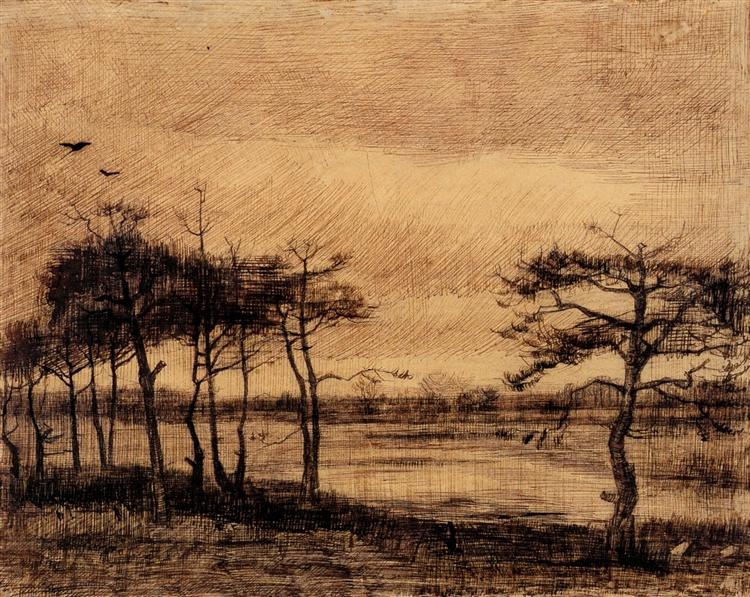
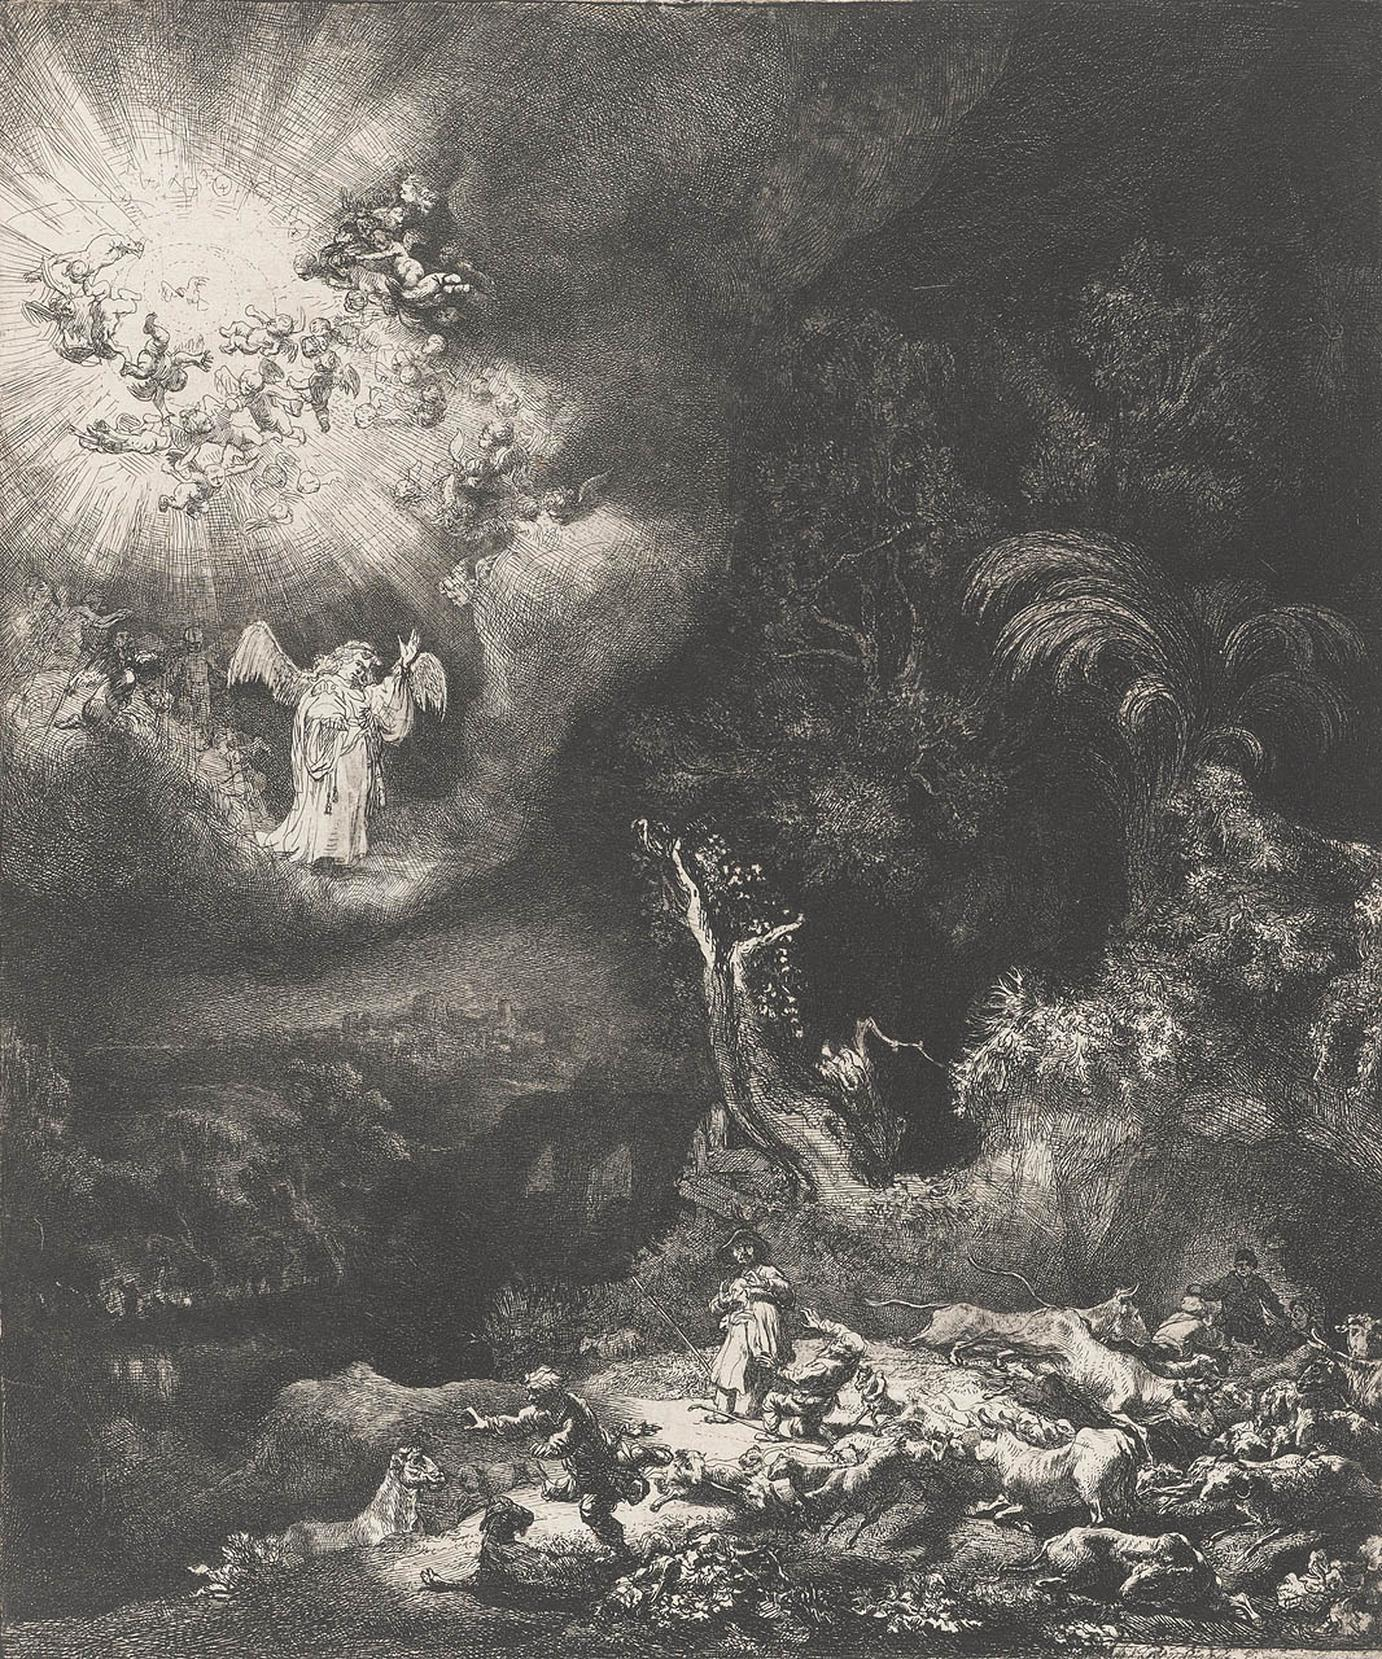
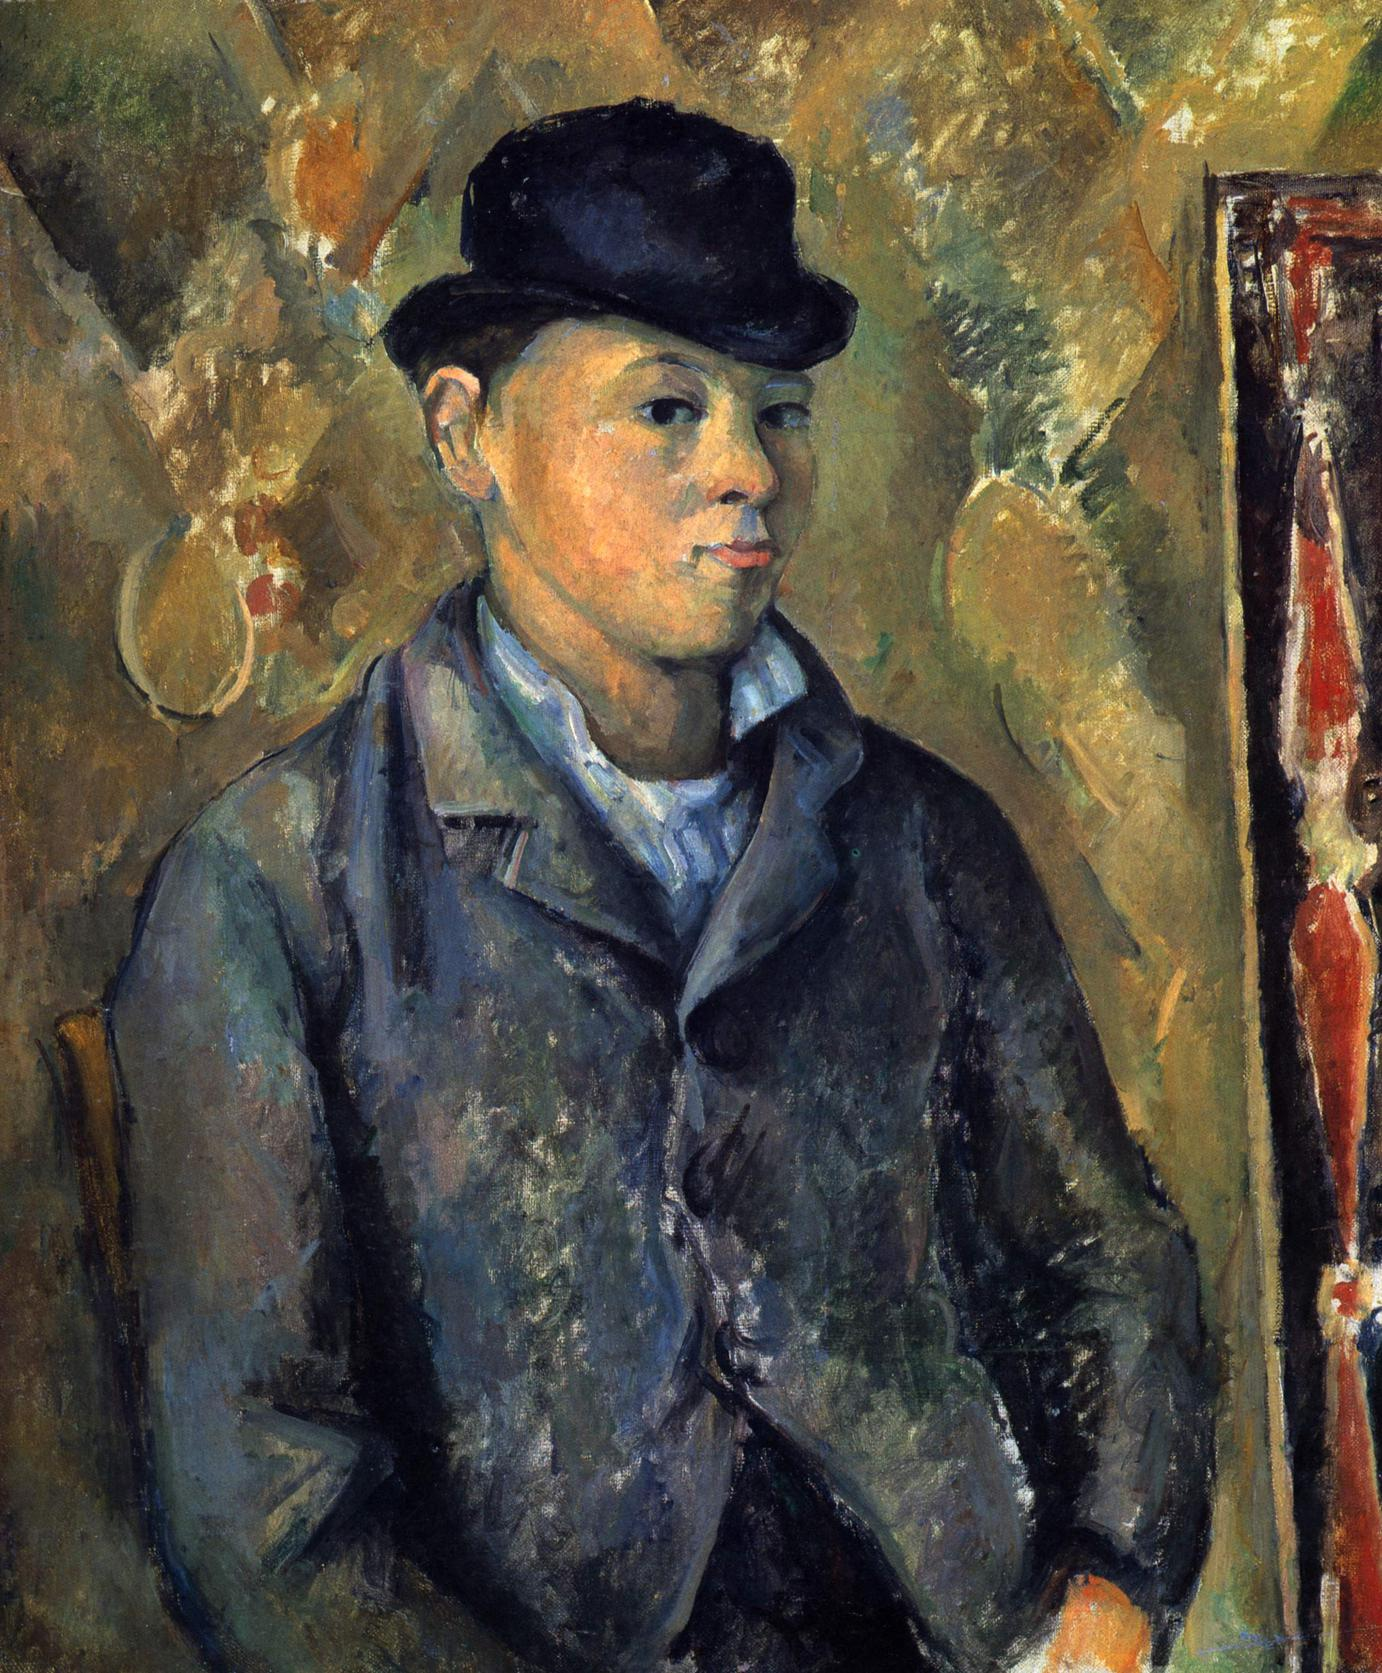
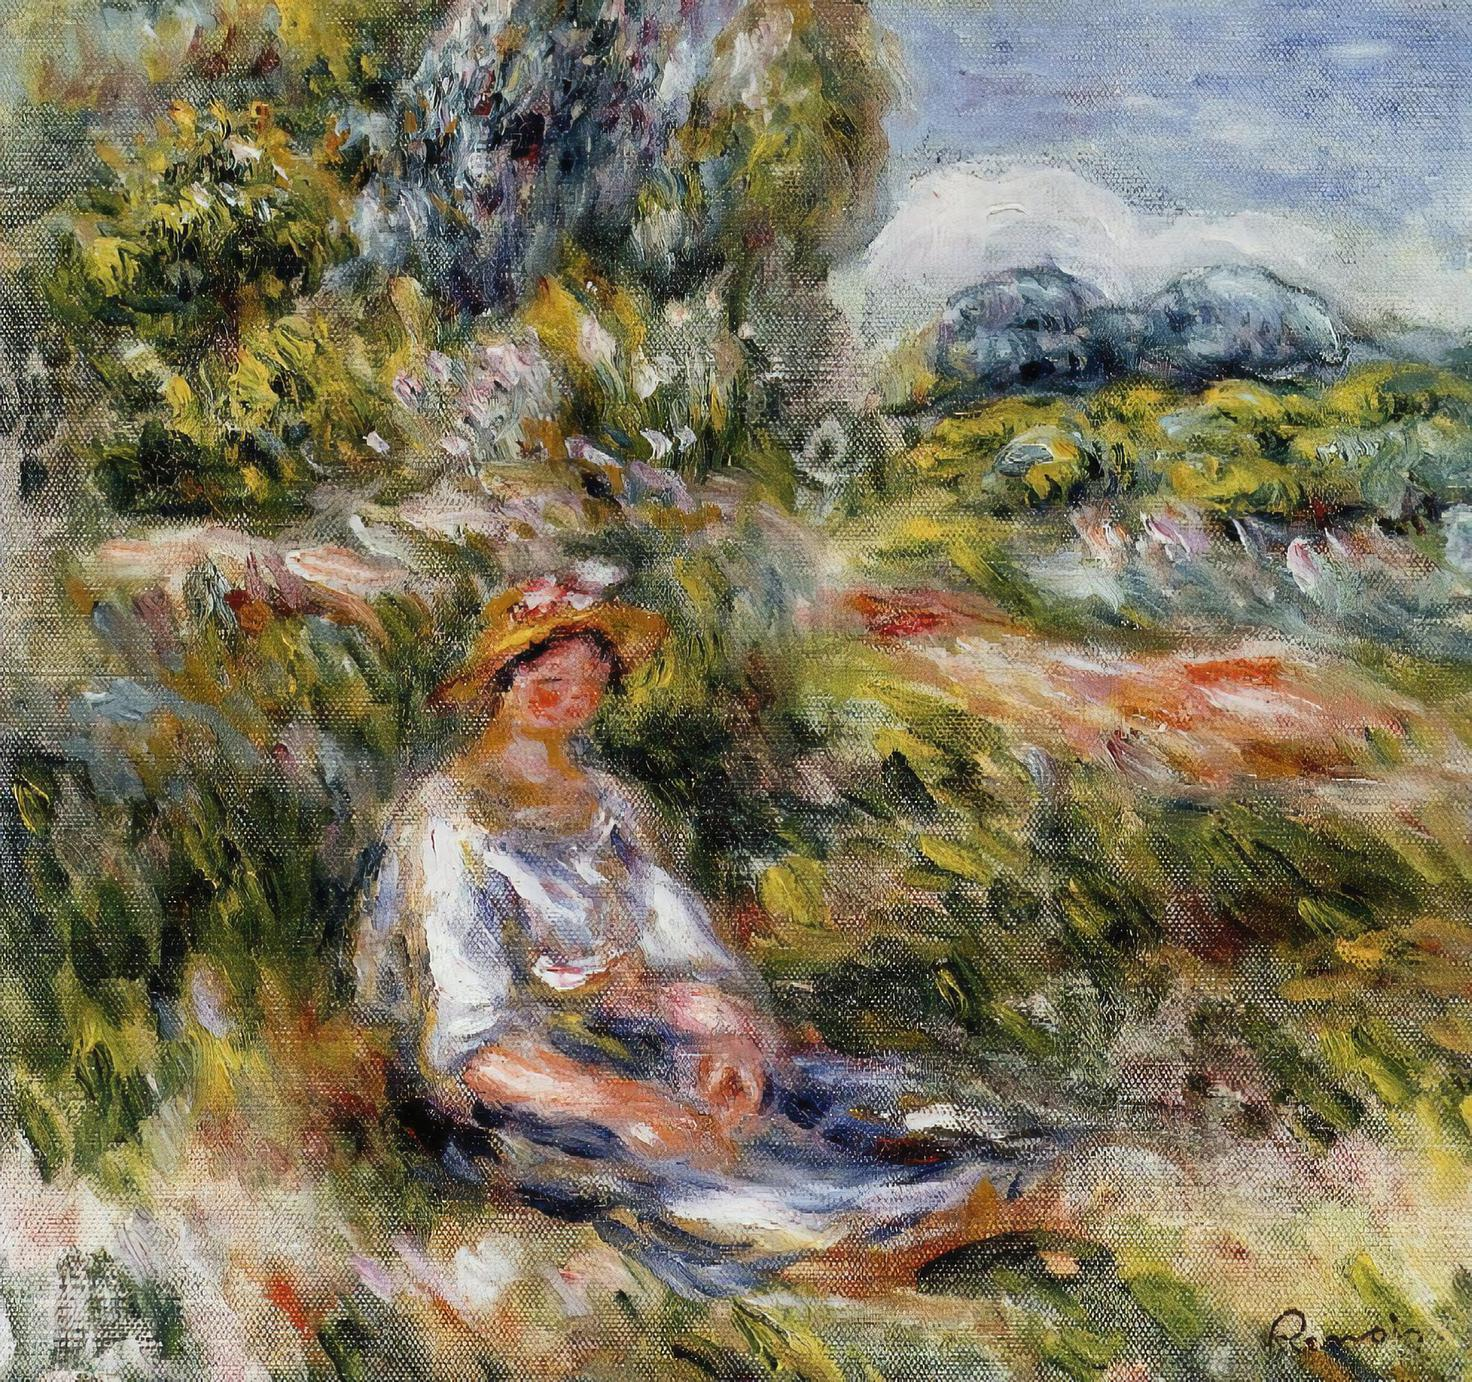
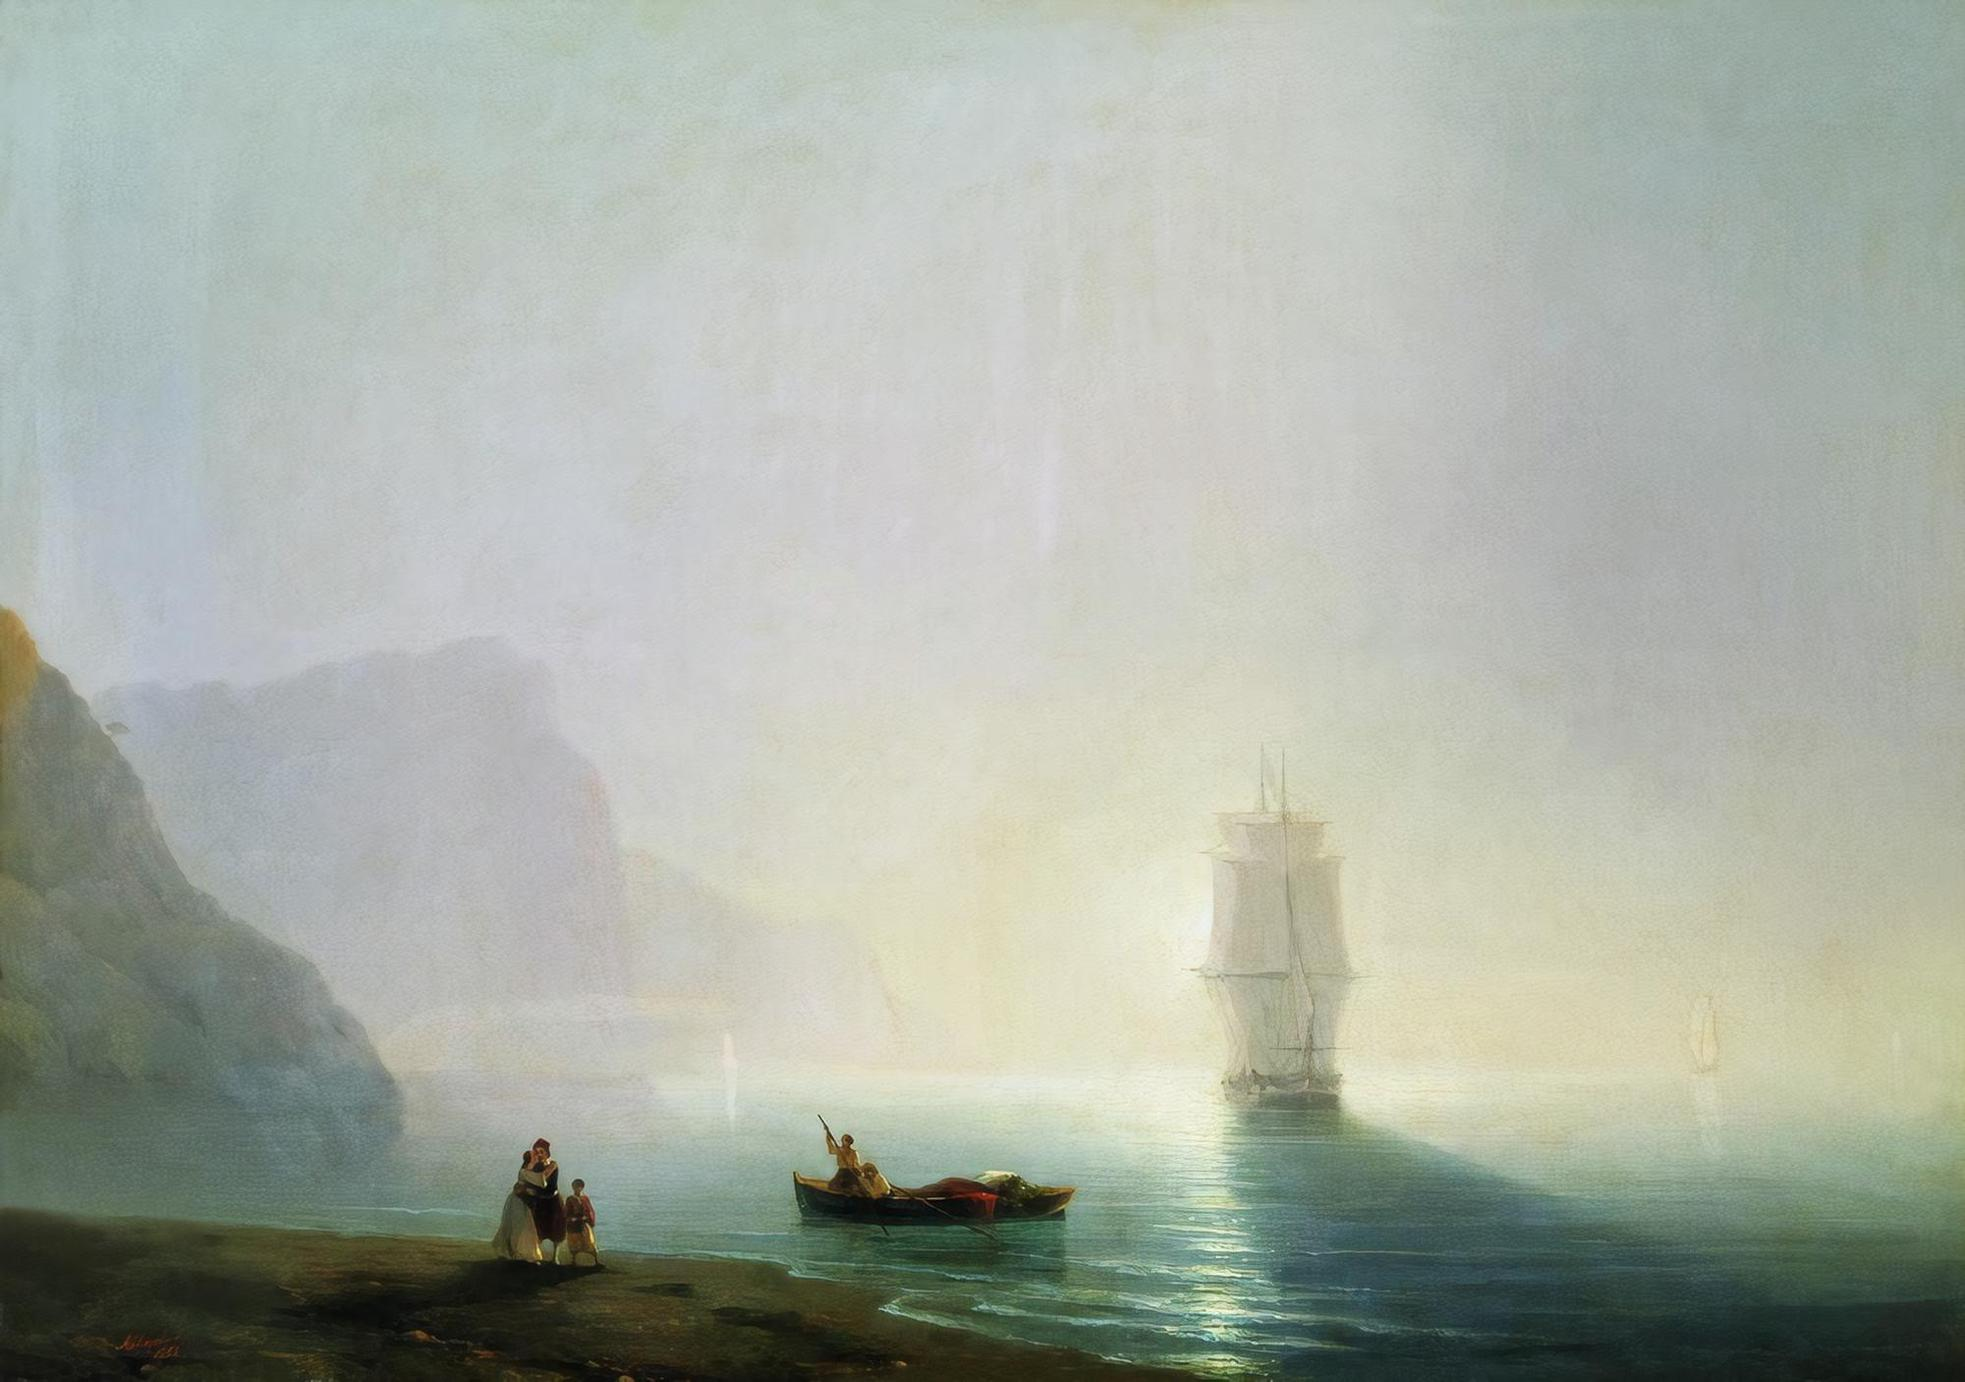

In [261]:
print('Dataset Overall info:')
pprint.pprint(dataset_art)
print('\n')

print('Dataset Schema:')
pprint.pprint(dataset_art.data.schema)
print('\n')

d: pd.DataFrame = dataset_art.select(range(0, 5)).to_pandas()
print('Dataset data example:')
pprint.pprint(d)
print('\n')

d['artist'] = dataset_art.features['artist'].int2str(d['artist'])
d['genre'] = dataset_art.features['genre'].int2str(d['genre'])
d['style'] = dataset_art.features['style'].int2str(d['style'])
d['image'] = d['image'].apply(lambda img_data: f'<img src="data:image/jpeg;base64,{base64.b64encode(img_data["bytes"]).decode("utf-8")}" width="100" />')
print('Dataset human-readable example:')
display(HTML(d.to_html(escape=False)))

Датасет в формате Apache Parquet, содержащий 81444 записей со следующей структурой:
- `image` - объект со значениями `bytes` и `path`, изображение хранится в байтах;
- `artist` - лейбл, обозначающий автора произведения;
- `genre` - лейбл, обозначающий жанр живописи прозведения;
- `style` - лейбл, обозначающий стилистическое направление произведения;

---

Создание общего датасета произведений искусства, состоит из следующих шагов:
1. поиск соотв по авторам в двух датасетах;
2. поиск соответствующих изображений автора среди всех подходящих изображений в датасете `wikiart`;
3. создание общего датасета произведений, содержащего ссылку на автора в датасете `best-artworks-of-all-time` и отфильтрованные изображения с лейблами из датасета `wikiart`; 


In [262]:
dataset_inter = dataset_artists_cleared.copy()


def get_wikiart_author_name(name: str) -> str or None:
    result = process.extractBests(
        name, dataset_art.features['artist'].names, limit=1, score_cutoff=85)
    if (not len(result)):
        return None
    found_name, found_score = result[0]
    return found_name


def get_wikiart_author_label_id(name: str) -> int:
    return dataset_art.features['artist'].str2int(name)


dataset_inter['wikiart_author_name'] = dataset_inter['name'].apply(
    get_wikiart_author_name)
dataset_inter = dataset_inter[~dataset_inter['wikiart_author_name'].isna()]
dataset_inter['wikiart_author_label_id'] = dataset_inter['wikiart_author_name'].apply(
    get_wikiart_author_label_id)


dataset_inter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 0 to 48
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   name                     36 non-null     object
 1   years                    36 non-null     object
 2   genre                    36 non-null     object
 3   nationality              36 non-null     object
 4   bio                      36 non-null     object
 5   wikipedia                36 non-null     object
 6   paintings                36 non-null     int64 
 7   artist_dir_path          36 non-null     object
 8   wikiart_author_name      36 non-null     object
 9   wikiart_author_label_id  36 non-null     int64 
dtypes: int64(2), object(8)
memory usage: 3.1+ KB


Часть авторов отфильтрована в связи с их отсутствием в датасете wikiart. Далее выгрузим все изображения для тех авторов, которые есть в датасете `best-artworks-of-all-time`.

In [263]:
allowed_artists = dataset_inter['wikiart_author_label_id'].values

dataset_art_processed: Dataset = dataset_art.add_column(
    'idx', range(0, len(dataset_art)))
dataset_art_processed = dataset_art_processed.select_columns(['artist', 'genre', 'style', 'idx'])
dataset_art_processed = dataset_art_processed.filter(lambda row: row['artist'] in allowed_artists)
dataset_art_df = dataset_art_processed.to_pandas()
dataset_art_df.info()
dataset_art_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14959 entries, 0 to 14958
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   artist  14959 non-null  int64
 1   genre   14959 non-null  int64
 2   style   14959 non-null  int64
 3   idx     14959 non-null  int64
dtypes: int64(4)
memory usage: 467.6 KB


artist  genre  style  idx
0      22      4     21    0
1      20      7      4    1
2      16      6     20    2
3      17      2     12    3
4      22     10     21    6

Итого, мы собрали датсет картин `dataset_art_df`, являющийся промежуточной таблицей, связывающей датасеты `wikiart` и `best-artworks-of-all-time`, который содержит 14959 строк.
Структура датасета:
- `idx` - индекс картины в датасете `wikiart`;
- `artist` - лейбл художника в датасете `wikiart` и идентификатор художника в `best-artworks-of-all-time` по столбцу `wikiart_author_label_id`;
- `genre` - лейбл жанра живописи, в котором написана картина;
- `style` - стилистическое направление, в котором написана картина.

Для примера возьмем 5 рандомных изображений, отобразим их и дополним информацией о художнике и самом произведении из соответствующих датасетов:

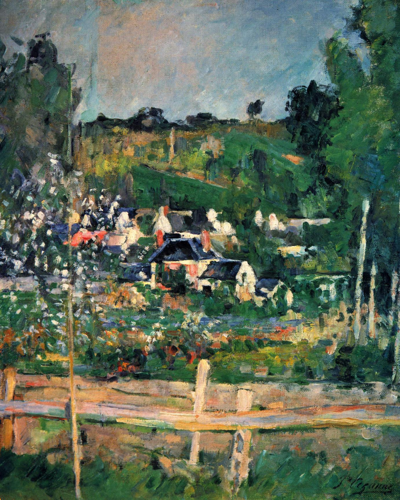

artist_name        artist_genre artist_nationality artist_years  \
0  Paul Cezanne  Post-Impressionism             French  1839 – 1906   

  artwork_genre  artwork_style  artwork_idx  
0     landscape  Impressionism        17076

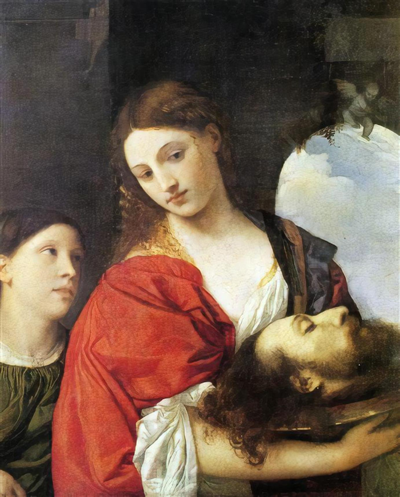

artist_name                artist_genre artist_nationality artist_years  \
0      Titian  High Renaissance,Mannerism            Italian  1488 - 1576   

        artwork_genre     artwork_style  artwork_idx  
0  religious_painting  High_Renaissance        50571

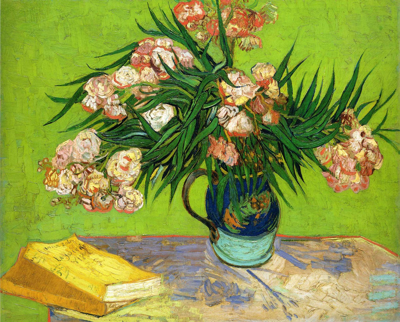

artist_name        artist_genre artist_nationality artist_years  \
0  Vincent van Gogh  Post-Impressionism              Dutch  1853 – 1890   

  artwork_genre       artwork_style  artwork_idx  
0    still_life  Post_Impressionism         8929

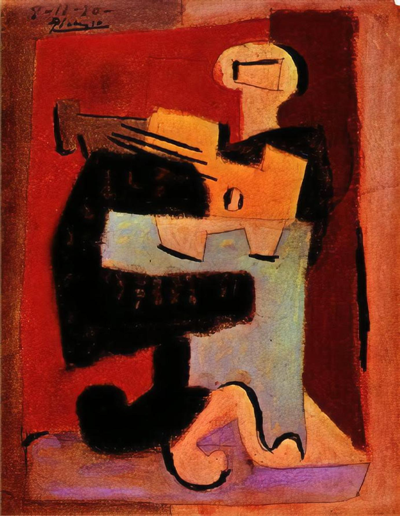

artist_name artist_genre artist_nationality artist_years   artwork_genre  \
0  Pablo Picasso       Cubism            Spanish  1881 - 1973  genre_painting   

  artwork_style  artwork_idx  
0        Cubism        18883

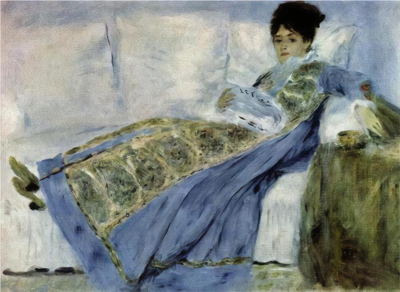

artist_name   artist_genre artist_nationality artist_years artwork_genre  \
0  Claude Monet  Impressionism             French  1840 - 1926      portrait   

   artwork_style  artwork_idx  
0  Impressionism          942

In [264]:
random.seed(30)

random_artwork_idx_list = [random.randint(0, len(dataset_art_df) - 1) for _ in range(5)]

def feature2readable(feature_name, feature_val):
    return dataset_art.features[feature_name].int2str(feature_val)


def make_readable(obj):
    artist, genre, style, idx = obj.to_dict().values()
    artist = dataset_inter[dataset_inter['wikiart_author_label_id']
                           == artist].iloc[0]
    
    artist_image = dataset_art[idx]['image']
    max_width = 400
    original_width, original_height = artist_image.size
    new_height = int(max_width * original_height / original_width)
    resized_image = artist_image.resize((max_width, new_height))
    return {
        'artist_name': artist['name'],
        'artist_genre': artist['genre'],
        'artist_nationality': artist['nationality'],
        'artist_years': artist['years'],
        'artwork_image': resized_image,
        'artwork_genre': feature2readable('genre', genre),
        'artwork_style': feature2readable('style', style),
        'artwork_idx': idx}


for random_artwork_idx in random_artwork_idx_list:
    random_artwork = dataset_art_df.iloc[random_artwork_idx]
    artwork_processed = make_readable(random_artwork)
    df = pd.DataFrame([artwork_processed]).drop(['artwork_image'], axis=1)
    display(artwork_processed['artwork_image'])
    display(df)

### Exploratory data analysis

В данно мразделе будет проведен разведовательный анализ данных собранных датасетов. 

**Распределение живописцев в топ-50 по национальности**

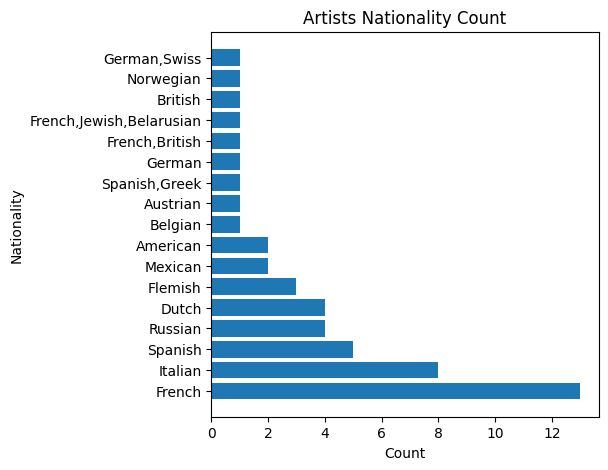

In [265]:
plt.figure(figsize=(5,5))
nationality_counts = dataset_artists['nationality'].value_counts()
plt.barh(nationality_counts.index, nationality_counts.values)
plt.xlabel('Count')
plt.ylabel('Nationality')
plt.title('Artists Nationality Count')
plt.show()

---
**Количество картин, написанное каждым из представленных живописцев**

/tmp/ipykernel_1006/2470782113.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dataset_artists[col1], rotation=90)


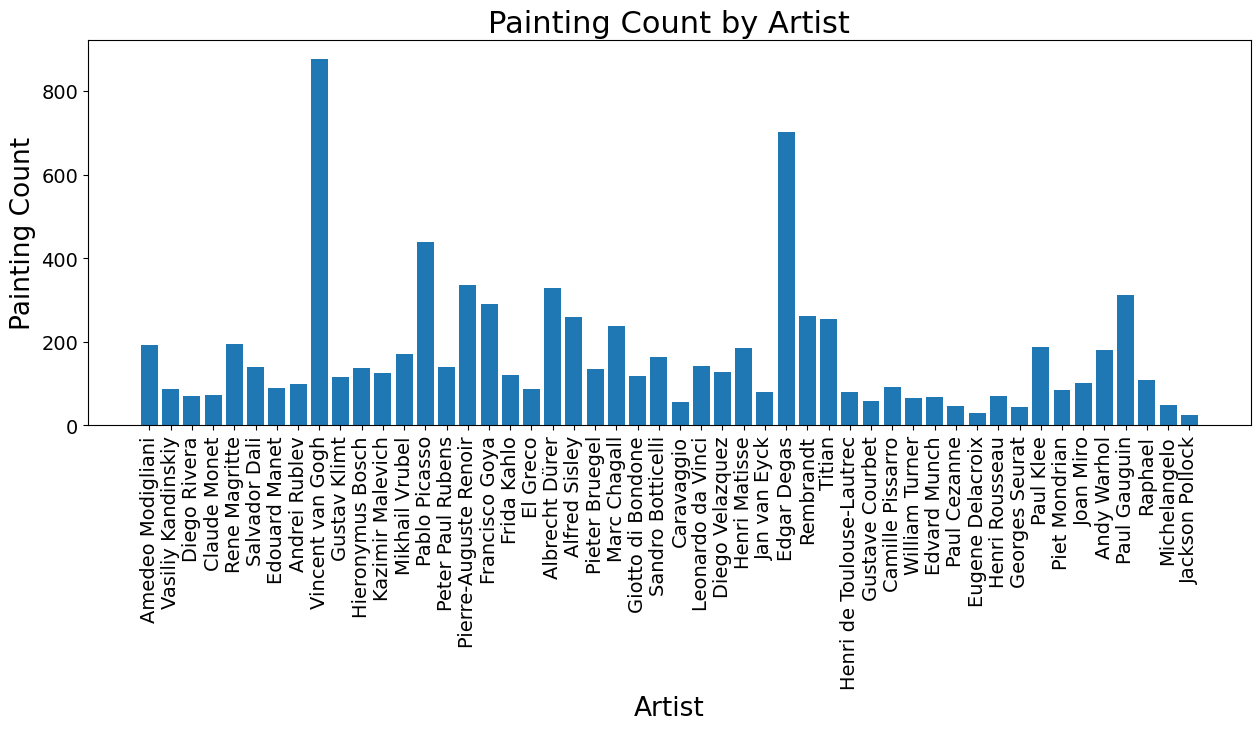

In [266]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

col1 = "name"
col2 = "paintings"

# Assuming 'artists' is your dataset
bar_plot = ax.bar(dataset_artists[col1], dataset_artists[col2])
ax.set_title("Painting Count by Artist", fontsize=22)
ax.set_xlabel("Artist", fontsize=19)
ax.set_ylabel("Painting Count", fontsize=19)
ax.set_xticklabels(dataset_artists[col1], rotation=90)

plt.show()

---
**Количество картин, сгруппированное по жанрам**

/tmp/ipykernel_1006/4168219456.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dataset_art_df['genre_label'], rotation=90)


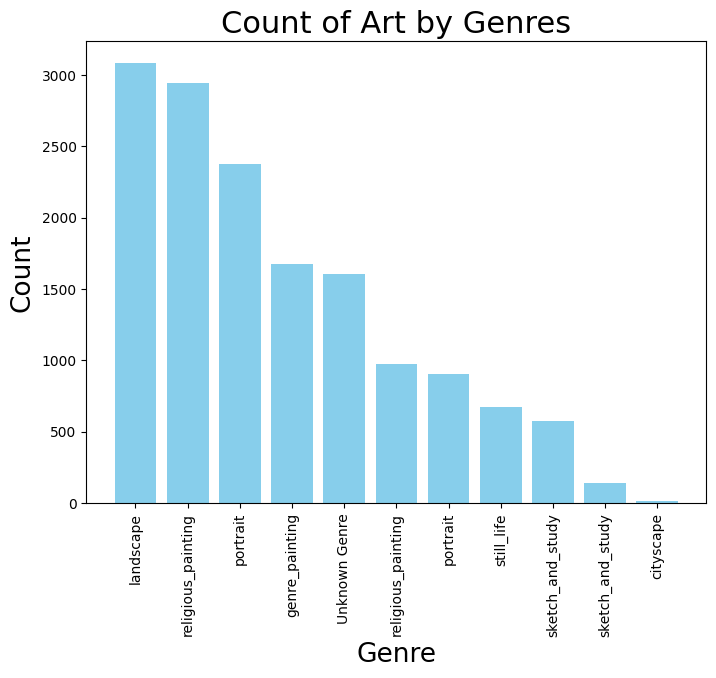

In [267]:

dataset_art_df['genre_label'] = dataset_art_df['genre'].map(lambda v: feature2readable('genre', v))
genre_counts = dataset_art_df['genre_label'].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(genre_counts.index, genre_counts.values, color='skyblue')
ax.set_title("Count of Art by Genres", fontsize=22)
ax.set_xlabel("Genre", fontsize=19)
ax.set_ylabel("Count", fontsize=19)
ax.set_xticklabels(dataset_art_df['genre_label'], rotation=90)
plt.show()

---
**Количество картин, сгруппированное по стилевым течениям**

/tmp/ipykernel_1006/989801156.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dataset_art_df['style_label'], rotation=90)


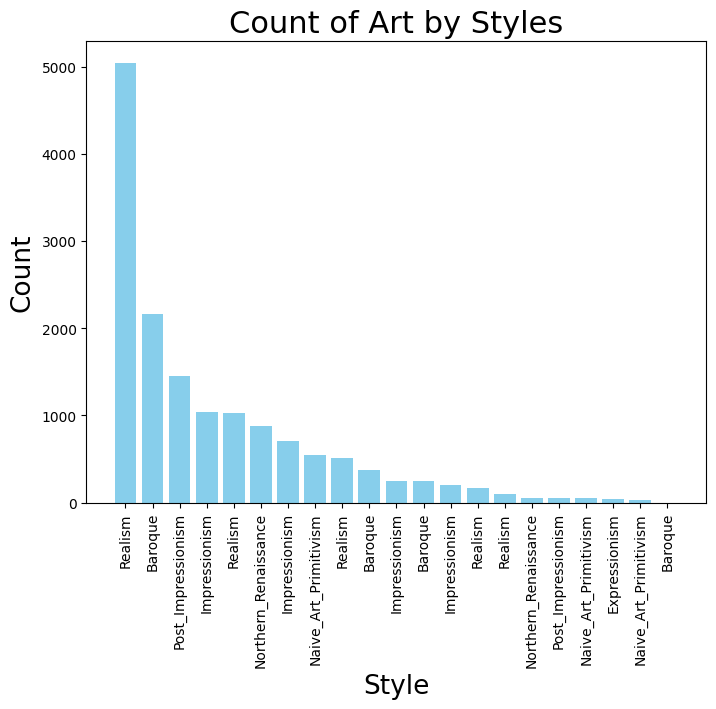

In [268]:
dataset_art_df['style_label'] = dataset_art_df['style'].map(lambda v: feature2readable('style', v))
genre_counts = dataset_art_df['style_label'].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(genre_counts.index, genre_counts.values, color='skyblue')
ax.set_title("Count of Art by Styles", fontsize=22)
ax.set_xlabel("Style", fontsize=19)
ax.set_ylabel("Count", fontsize=19)
ax.set_xticklabels(dataset_art_df['style_label'], rotation=90)
plt.show()

---
**Количество картин у каждого художника по каждому из представленных жанров (абсолютные значения)**

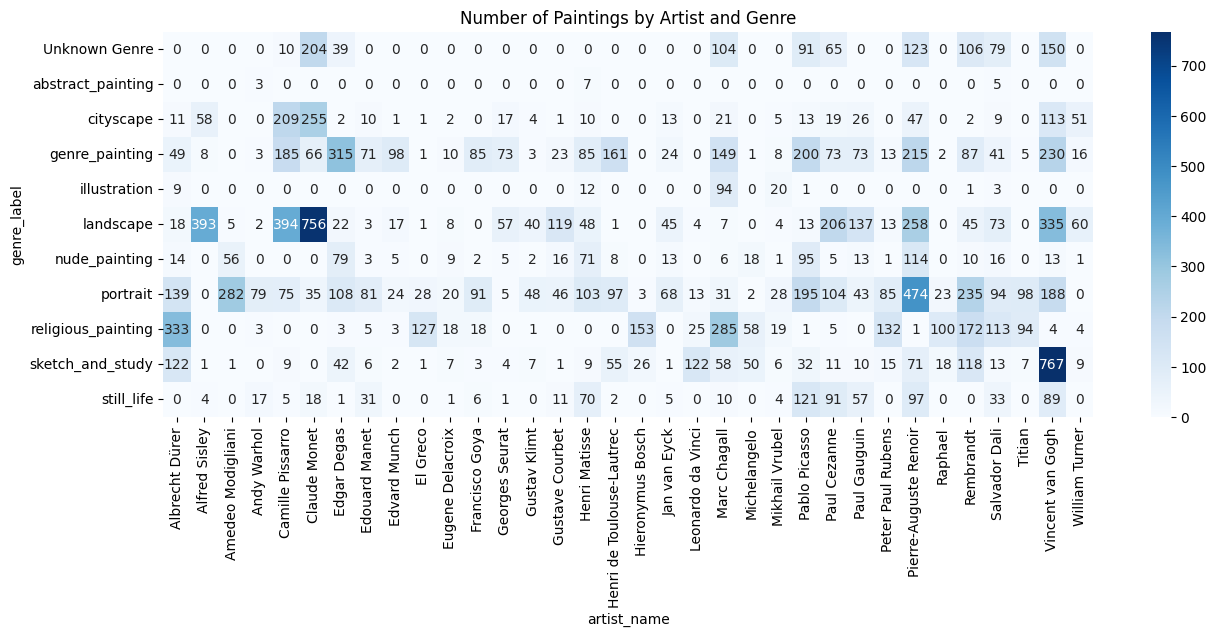

In [269]:
dataset_art_df['artist_name'] = dataset_art_df['artist'].map(
    lambda v: dataset_inter[dataset_inter['wikiart_author_label_id'] == v].iloc[0]['name'])

artist_genre_heatmap = dataset_art_df[['artist_name', 'genre_label']].pivot_table(
    index='genre_label', columns=['artist_name'], aggfunc=len, fill_value=0)

plt.figure(figsize=(15, 5))
heatmap = sns.heatmap(artist_genre_heatmap, annot=True,
                      cmap='Blues', cbar=True, fmt='d')
plt.title('Number of Paintings by Artist and Genre')
plt.show()

---
**Количество картин у каждого художника по каждому из представленных жанров (относительные общего числа картин художника значения, %)**

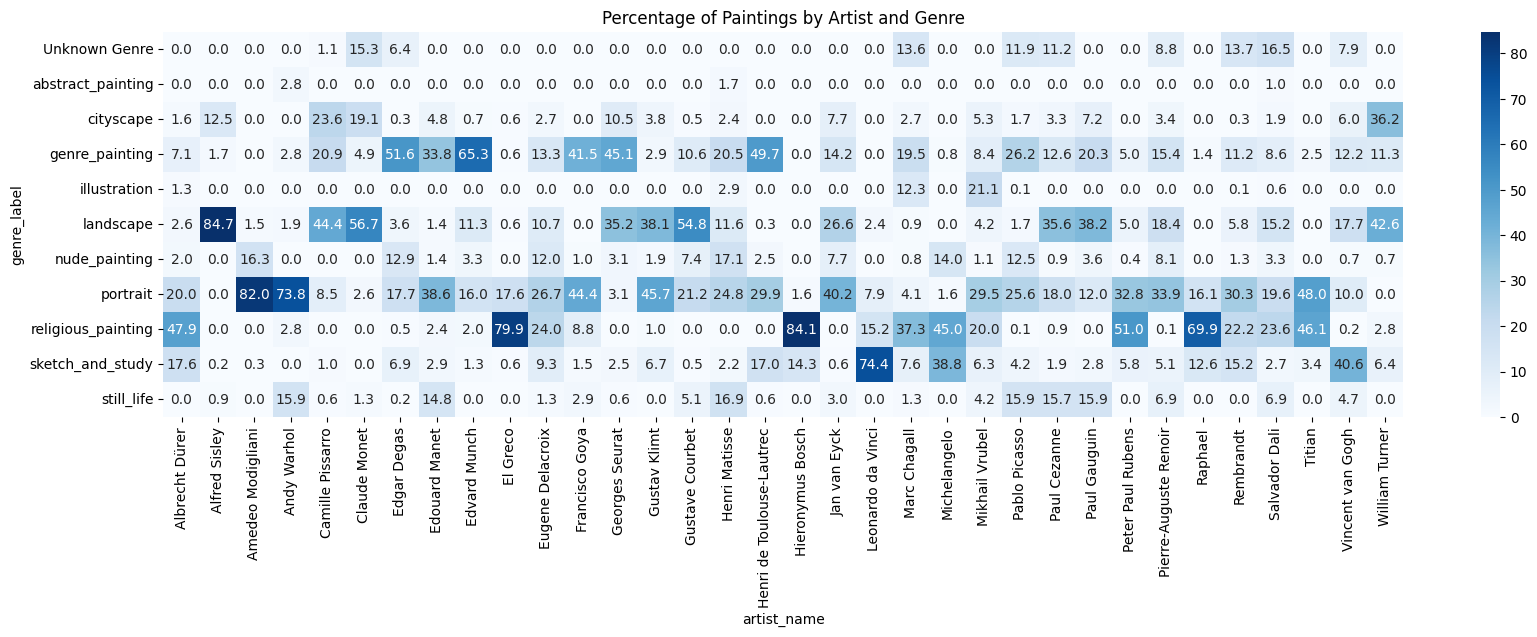

In [270]:
artist_genre_heatmap = dataset_art_df[['artist_name', 'genre_label']].pivot_table(
    index='genre_label', columns=['artist_name'], aggfunc=len, fill_value=0)


total_works_by_artist = artist_genre_heatmap.sum(axis=0)
heatmap_data_percentages = artist_genre_heatmap.div(total_works_by_artist, axis=1) * 100
plt.figure(figsize=(20, 5))
heatmap = sns.heatmap(heatmap_data_percentages, annot=True, fmt='.1f', cmap='Blues', cbar=True)
plt.title('Percentage of Paintings by Artist and Genre')
plt.show()

---
**Количество картин у каждого художника по каждому из представленных течений (абсолютные значения)**

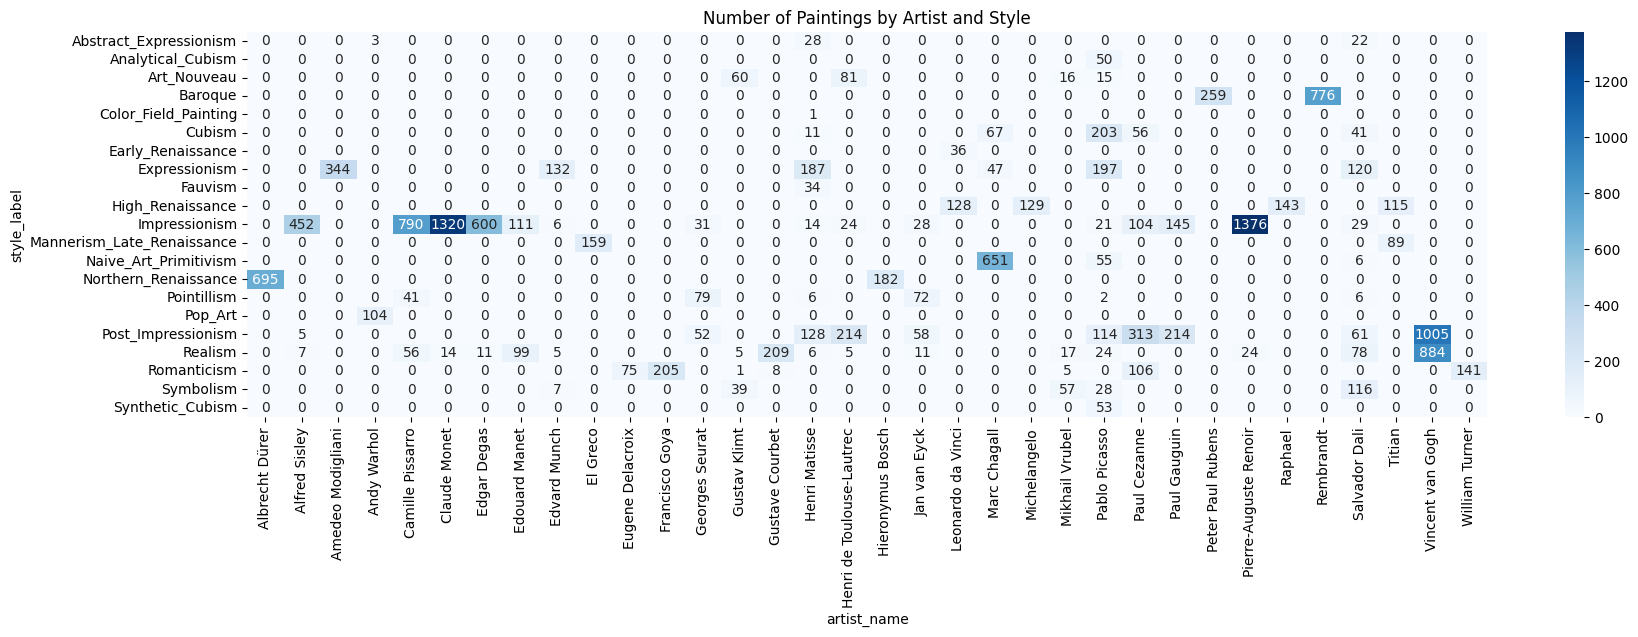

In [271]:
artist_genre_heatmap = dataset_art_df[['artist_name', 'style_label']].pivot_table(
    index='style_label', columns=['artist_name'], aggfunc=len, fill_value=0)

plt.figure(figsize=(20, 5))
heatmap = sns.heatmap(artist_genre_heatmap, annot=True,
                      cmap='Blues', cbar=True, fmt='d')
plt.title('Number of Paintings by Artist and Style')
plt.show()

---
**Количество картин у каждого художника по каждому из течений (относительные общего числа картин художника значения, %)**

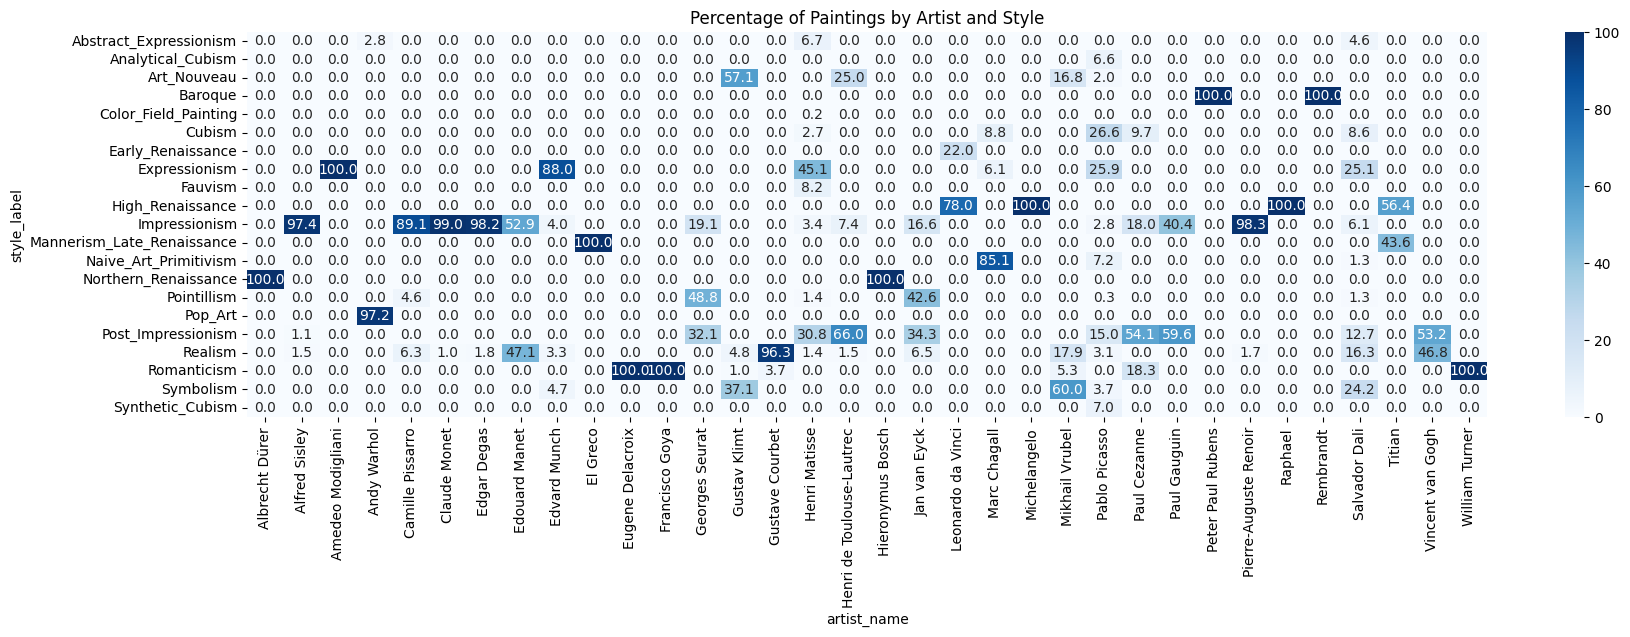

In [272]:
artist_genre_heatmap = dataset_art_df[['artist_name', 'style_label']].pivot_table(
    index='style_label', columns=['artist_name'], aggfunc=len, fill_value=0)


total_works_by_artist = artist_genre_heatmap.sum(axis=0)
heatmap_data_percentages = artist_genre_heatmap.div(total_works_by_artist, axis=1) * 100
plt.figure(figsize=(20, 5))
heatmap = sns.heatmap(heatmap_data_percentages, annot=True, fmt='.1f', cmap='Blues', cbar=True)
plt.title('Percentage of Paintings by Artist and Style')
plt.show()

### Возможные способы примнения

Собранный датасет может быть использован в следующих кейсах:
- анализ стилистических особенностей и поиск паттернов в произведениях различных жанров, исследование эволюции и расширение теоретического базиса художественного искусства;
- генерация картин с визуальными характеристиками определенных художников, жанров, стилистических течений;
- персонализированный подбор репродукций искусства при проектировании дизайна интерьеров;
- определение подлинности художественных произведений и атрибуция произведений за неизвестным авторством.